In [1]:
import os, time, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
# sys.path.append('/home/stringlab/Desktop/approxineuro/approxineuro')
from approxineuro import datasets, metrics
from ann_utils import ResNet, model_urls

%matplotlib inline

device = torch.device('cuda')

### make model

In [2]:
model = ResNet()

In [9]:
state_dict = torch.hub.load_state_dict_from_url(model_urls['resnet18'], progress=True)
model_dict = model.state_dict()
for k, v in model_dict.items():
    if 'num_batches_tracked' in k:
        continue
    for pk, pv in state_dict.items():
        if k == pk:
            model_dict[k].copy_(pv)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/carsen/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
model.eval()
if torch.cuda.is_available():
    model.to('cuda')

### load stims

[27  3 22 18 23 17 21 28]


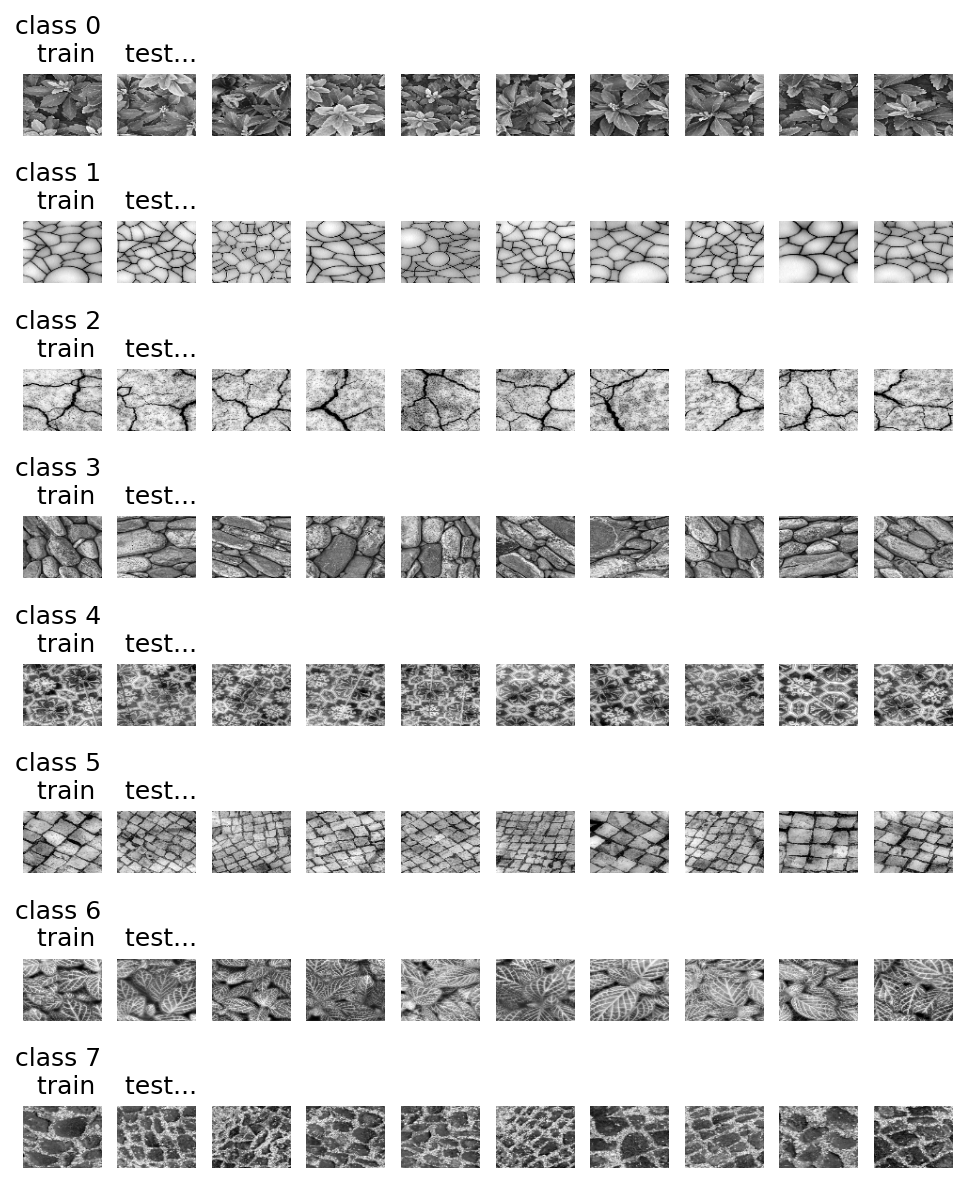

In [4]:
# take indices from miguel's experiments
import random
seed = 1
np.random.seed(seed)
random.seed(seed)
sample_classes = np.random.choice(np.arange(32), size=8, replace=False) # np.array([3, 24, 6, 12, 29, 30, 13, 15]) for Miguel's experiments
print(sample_classes)
timgs, labels = datasets.load_txt32('/home/carsen/dm11_pachitariu/data/STIM/',
                                    inds = np.array([3, 24, 6, 12, 29, 30, 13, 15]))
n_stims, Ly, Lx = timgs.shape
n_classes = labels.max() + 1
n_reps = n_stims // n_classes

plt.figure(figsize=(8,10), dpi=150, facecolor='w')
for i in range(min(n_stims, 80)):
    plt.subplot(8,10,i+1)
    plt.imshow(timgs[(i//10) * n_reps + i%10], cmap='gray')
    if i%10 == 0:
        plt.title(f'class {i//10} \n train')
    elif i%10 == 1:
        plt.title(f' \n test...')
    plt.axis('off')
    

### compute responses + metrics

In [11]:
import imp
imp.reload(metrics)

ntrains = 2 ** np.arange(0, 9)
ntrains = np.append(ntrains, np.array([400]))
ntrains = ntrains[:1]
n_ntrain = len(ntrains)
n_layers = 5
layers = np.arange(1, n_layers+1)
accsL = np.nan * np.zeros((n_ntrain, n_layers, n_classes,n_classes))
accsK = np.nan * np.zeros((n_ntrain, n_layers, n_classes, n_classes)) 
ltile = np.tile(layers[:,np.newaxis, np.newaxis], (1, n_classes, n_classes))

for l, layer in enumerate(layers):
    ### compute responses for model
    X = model.responses(timgs, layer=layer, batch_size=8)
    print(X.shape, X.max(), X.min())
    X = X.reshape(X.shape[0], -1)
    print(X.shape)

    for n, ntrain in enumerate(ntrains):
        print(f'>>> ntrain = {ntrain}')
        itrain = np.zeros(n_stims, 'bool')
        for k in range(ntrain):
            itrain[k::n_reps] = True
        itest = ~itrain
        
        ### compute performance on texture classification
        for i0 in range(n_classes):
            for i1 in range(i0+1, n_classes):
                accsL[n,l,i0,i1], accsK[n,l,i0,i1] = metrics.classifiers(X, labels, itrain, itest, 
                                                                 ipair=[i0, i1], verbose=False)

        print(f'LAYER {layer}; logreg: {np.nanmean(accsL[n,l]):.2f}, 1-NN: {np.nanmean(accsK[n,l]):.2f}')

(4000, 64, 17, 21) 5.711370468139648 0.0
(4000, 22848)
>>> ntrain = 1
LAYER 1; logreg: 0.52, 1-NN: 0.51
(4000, 64, 17, 21) 7.396639347076416 0.0
(4000, 22848)
>>> ntrain = 1
LAYER 2; logreg: 0.55, 1-NN: 0.55
(4000, 128, 9, 11) 5.839323997497559 0.0
(4000, 12672)
>>> ntrain = 1
LAYER 3; logreg: 0.84, 1-NN: 0.87
(4000, 256, 5, 6) 3.336793899536133 0.0
(4000, 7680)
>>> ntrain = 1
LAYER 4; logreg: 0.95, 1-NN: 0.97
(4000, 512, 3, 3) 30.58513641357422 0.0
(4000, 4608)
>>> ntrain = 1
LAYER 5; logreg: 0.93, 1-NN: 0.96


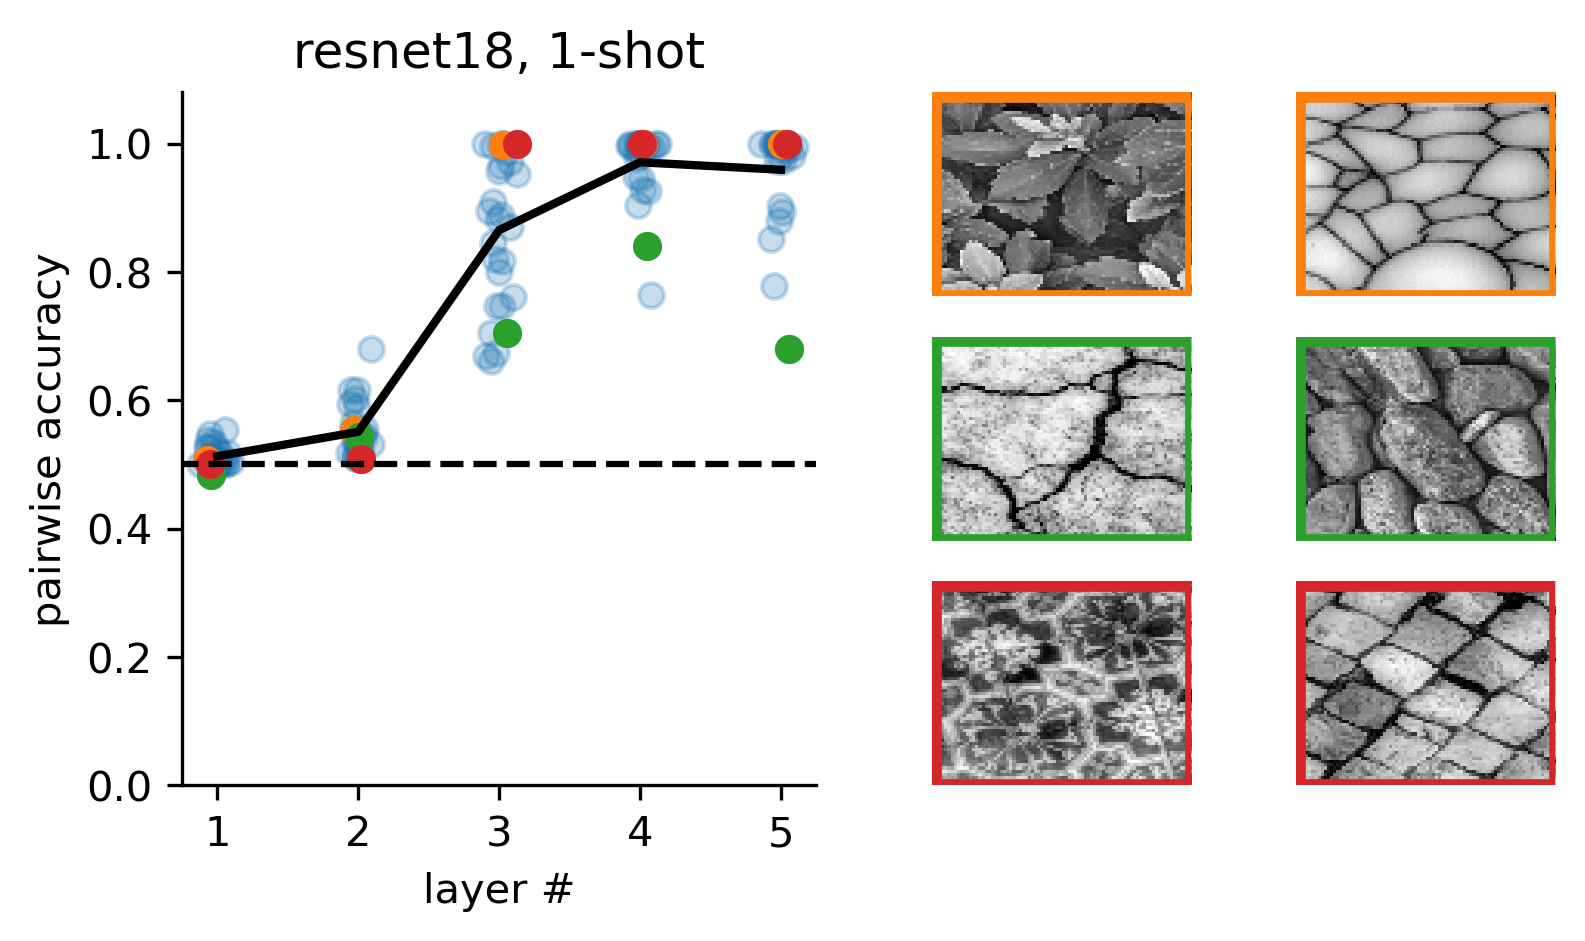

In [12]:
n = 0
from matplotlib.patches import Rectangle
fig=plt.figure(figsize=(6,3), dpi=300, facecolor='w')
ax = fig.add_subplot(1,2,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xl = ltile + 0.05*np.random.randn(*ltile.shape)
ax.scatter(xl, accsK[n], alpha=0.25)
for i in np.arange(0, 6, 2):
    ax.scatter(xl[:,i,i+1], accsK[n,:,i,i+1], alpha=1)

ax.plot(layers, np.nanmean(accsK[n], axis=(-2,-1)), color='k', lw=2)
ax.set_ylim([0,1.08])
ax.set_xlabel('layer #')
ax.set_ylabel('pairwise accuracy')
ax.set_title(f'resnet18, {ntrains[n]}-shot')
ax.plot([0, 6], [0.5, 0.5], 'k--')
ax.set_xlim([0.75, 5.25])
#ax.set_title('texture classification')
for i in np.arange(0, 6, 2):
    for j in range(2):
        ax = fig.add_subplot(3,4, 2*i + 3 + j)
        ax.imshow(timgs[n_reps*(i+j)], cmap='gray')
        ax.add_patch(Rectangle([0,0], Lx, Ly, edgecolor=f'C{i//2+1}', facecolor='none', lw=4))
        ax.axis('off')

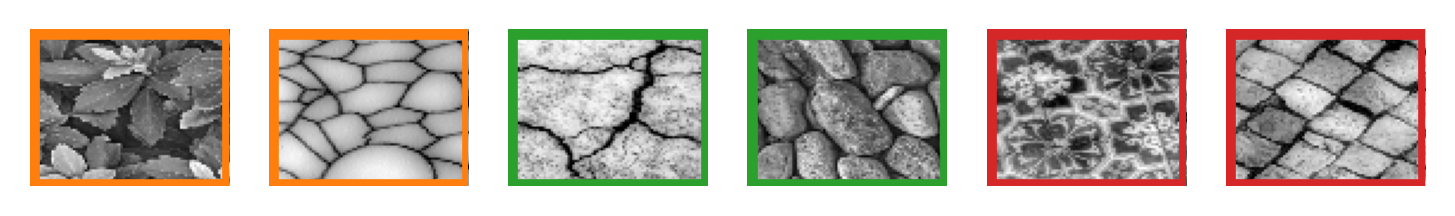

In [13]:
fig=plt.figure(figsize=(6,3), dpi=300, facecolor='w')
for i in np.arange(0, 6, 2):
    for j in range(2):
        ax = fig.add_subplot(1,6, i + j+1)
        ax.imshow(timgs[n_reps*(i+j)], cmap='gray')
        ax.add_patch(Rectangle([0,0], Lx, Ly, edgecolor=f'C{i//2+1}', facecolor='none', lw=4))
        ax.axis('off')
